<h3 align="center">Analisi lista passeggeri Titanic</h3>

---  
  
Yapping vario, spieghiamo il fatto che usiamo il dataset della competizione  
https://www.kaggle.com/competitions/titanic/overview  
  
Spieghiamo il fatto che è già diviso in dataset di training e di testing, quello di testing non ha la variabile target. Nonostante ciò, lo possiamo comunque usare per ricavare informazioni sul dataset.





In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

df = pd.concat([train_df, test_df], ignore_index=True)

print(df.info())
print(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   

                                                Name     Sex   Age  SibSp  \
0             

Trascurando i "Survived" mancanti per le entry del dataset di test, procediamo a risolvere i parametri mancanti.  
Iniziando dalla colonna "Embarked", sono assenti solo due valori per le seguente passeggere:

In [6]:
print(df[df['Embarked'].isna()])

     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


Notiamo che le due condividono cabina, identificativo e prezzo del biglietto, il che implica che si siano imbarcate allo stesso porto. Tramite una ricerca, riscontriamo che Amelie Icard era la domestica di Martha Evelyn Stone, ed entrambe si sono imbarcate al porto di Southampton.

In [20]:
df.loc[df['PassengerId'] == 830, 'Embarked'] = 'S'
df.loc[df['PassengerId'] == 62, 'Embarked'] = 'S'

Per la gestione delle età mancanti, è opportuno verificare la presenza di eventuali pattern in base ad altri fattori. Il grafico seguente rappresenta la distribuzione dell'età in base al sesso ed alla classe di appartenenza

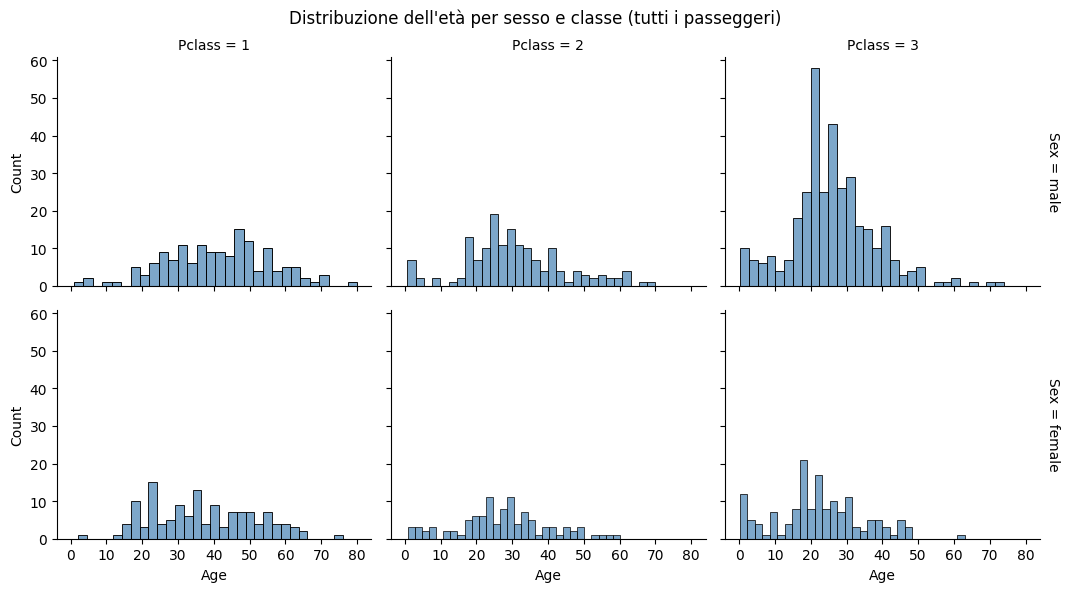

In [14]:
g = sns.FacetGrid(df, row="Sex", col="Pclass", margin_titles=True, height=3, aspect=1.2)
g.map(sns.histplot, "Age", bins=30, color="steelblue", alpha=0.7, kde=False)
# per avere più tacche sull'asse x
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(0, 85, 10))  # Adjust range and step as needed
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso e classe (tutti i passeggeri)")
plt.show()

Notiamo che ogni classe presenta una distribuzione diversa dell'età: ad esempio, i maschi in terza classe hanno un importante picco tra i 20 e i 30 anni, mentre le femmine della stessa classe hanno un picco tra i 18-24 e sotto i 2 anni.  
Da ciò possiamo dedurre che conviene assegnare l'età in base a questi parametri. In seguito, assegnamo l'età in base al valore mediano del gruppo di appartenenza.

In [21]:
median_ages = df.groupby(['Sex', 'Pclass'])['Age'].median()
df['Age'] = df.apply(
    lambda row: median_ages[row['Sex'], row['Pclass']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

Passiamo ora alla gestione del Fare. Una singola entry ha il valore mancante, corrispondente ad un maschio di terza classe che viaggia da solo.

In [22]:
print(df[df['Fare'].isna()])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Per assegnargli il fare più opportuno, possiamo ricavare il prezzo mediano di tutti i maschi nella sue stesse circostanze, ovvero passeggeri di terza classe solitari.

In [24]:
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
print(df[df['PassengerId'] == 1044]['Fare'])

1043    7.8542
Name: Fare, dtype: float64


Cercando in archivi online, risulta che il prezzo effettivo del passegero era di 7£, sufficentemente vicino a quello stimato.

C:\Users\Astolfo\AppData\Local\Temp\ipykernel_6976\1882907563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Survived'] = df_plot['Survived'].map({0: 'Not Survived', 1: 'Survived'})


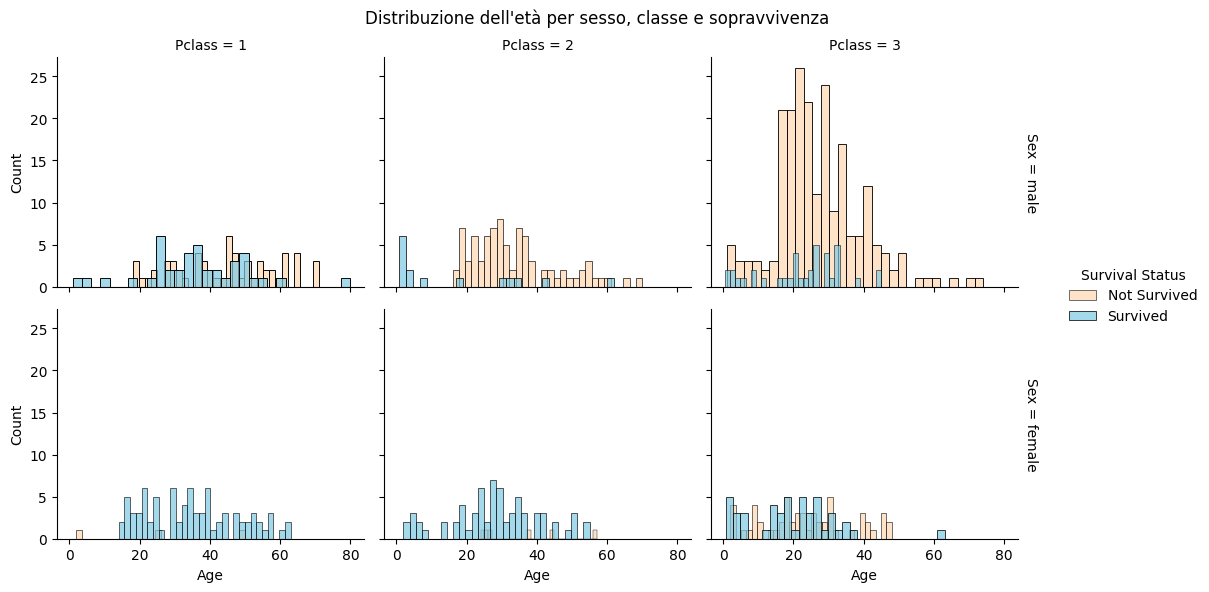

In [18]:
df_plot = df.dropna(subset=['Survived', 'Age'])
df_plot['Survived'] = df_plot['Survived'].map({0: 'Not Survived', 1: 'Survived'})
survival_palette = {'Survived': '#7ec8e3', 'Not Survived': '#ffd8b1'}  # light blue, light orange
g = sns.FacetGrid(
    df_plot,
    row="Sex",
    col="Pclass",
    hue="Survived",
    margin_titles=True,
    height=3,
    aspect=1.2,
    palette=survival_palette
)
g.map(sns.histplot, "Age", bins=30, alpha=0.7, kde=False)
g.add_legend(title="Survival Status")
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso, classe e sopravvivenza")
plt.show()

qui ci infilo i link, poi mettiamo tipo le citations idk  

kaggle  
https://www.kaggle.com/competitions/titanic/overview  

quelle senza Embarked  
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html  

composizione dei ponti  
https://www.encyclopedia-titanica.org/titanic-deckplans  

"fonte" sul fatto che la lettera della cabina identifica il ponte  
https://www.ggarchives.com/OceanTravel/Titanic/01-PlanningBuildingLaunching/Decks-ComprehensiveDetails.html  